In [1]:
from torch.utils.data.dataloader import DataLoader
import yaml
import os
from modules.dataset import split_subject_data, read_json_file, ImageDataset
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def verify_dataloader(
    dataloader: DataLoader,
    num_samples: int = 4,
    stage: str = 'vqvae',
) -> None:
    """
    Verify dataloader by visualizing a batch of data.
    
    Args:
        dataloader: The DataLoader to verify
        num_samples: Number of samples to visualize
        stage: Either 'vqvae' or 'diffusion'
        save_path: If provided, save the plot to this path
    """
    # Get a batch of data
    batch = next(iter(dataloader))
    
    if stage == 'vqvae':
        images = batch
        fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
        
        for i in range(min(num_samples, len(images))):
            img = images[i].squeeze().numpy()
            if axes.ndim == 1:
                ax = axes[i]
            else:
                ax = axes
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Sample {i+1}')
            
    else:  # diffusion stage
        images, edges, semantic_maps = batch
        fig, axes = plt.subplots(3, num_samples, figsize=(4*num_samples, 12))
        
        for i in range(min(num_samples, len(images))):
            # Plot original image
            img = images[i].squeeze().numpy()
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Image {i+1}')
            
            # Plot edge
            edge = edges[i].squeeze().numpy()
            axes[1, i].imshow(edge, cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title(f'Edge {i+1}')
            
            # Plot semantic map (show first channel if one-hot encoded)
            if semantic_maps[i].ndim == 3:  # one-hot encoded
                semantic = np.argmax(semantic_maps[i].numpy(), axis=0)
            else:
                semantic = semantic_maps[i].squeeze().numpy()
            axes[2, i].imshow(semantic, cmap='tab10')
            axes[2, i].axis('off')
            axes[2, i].set_title(f'Semantic {i+1}')
    
    plt.tight_layout()
    plt.show()
    
    # Print shape information
    print("\nBatch information:")
    if stage == 'vqvae':
        print(f"Images shape: {images.shape}")
    else:
        print(f"Images shape: {images.shape}")
        print(f"Edges shape: {edges.shape}")
        print(f"Semantic maps shape: {semantic_maps.shape}")
    
    # Print value ranges
    if stage == 'vqvae':
        print(f"\nImage value range: [{images.min():.2f}, {images.max():.2f}]")
    else:
        print(f"\nValue ranges:")
        print(f"Images: [{images.min():.2f}, {images.max():.2f}]")
        print(f"Edges: [{edges.min():.2f}, {edges.max():.2f}]")
        print(f"Semantic maps: [{semantic_maps.min():.2f}, {semantic_maps.max():.2f}]")

In [3]:
# Read the config file #
with open('config/config.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
print(config)

dataset_config = config['dataset_params']
autoencoder_config = config['autoencoder_params']
train_config = config['train_params']

# Set the desired seed value #
seed = train_config['seed']

data_indices_json = read_json_file(os.path.join(dataset_config['im_path'], 'dataset_index_mapping.json'))

train_indices, test_indices = split_subject_data(data_indices_json, num_test_subjects=train_config['leave_out_subjects'], random_seed=seed)

train_dataset = ImageDataset(train_indices, dataset_config['im_path'], data_indices_json, 'vqvae')

train_dataloader = DataLoader(train_dataset, batch_size=train_config['autoencoder_batch_size'], shuffle=True)

{'dataset_params': {'im_path': 'processed_data/', 'im_channels': 1, 'im_size': 256, 'name': 'medical_image'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0015, 'beta_end': 0.0195}, 'ldm_params': {'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2}, 'autoencoder_params': {'z_channels': 4, 'codebook_size': 16384, 'down_channels': [64, 128, 256, 256], 'mid_channels': [256, 256], 'down_sample': [True, True, True], 'attn_down': [False, False, False], 'norm_channels': 32, 'num_heads': 8, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2}, 'train_params': {'seed': 42, 'task_name': 'test_try', 'leave_out_subjects': 10, 'ldm_batch_size': 36, 'autoencoder_batch_size': 12, 'reconstruction_weight': 1.0, 'disc_start': 35000, 'disc_weight': 0.5,

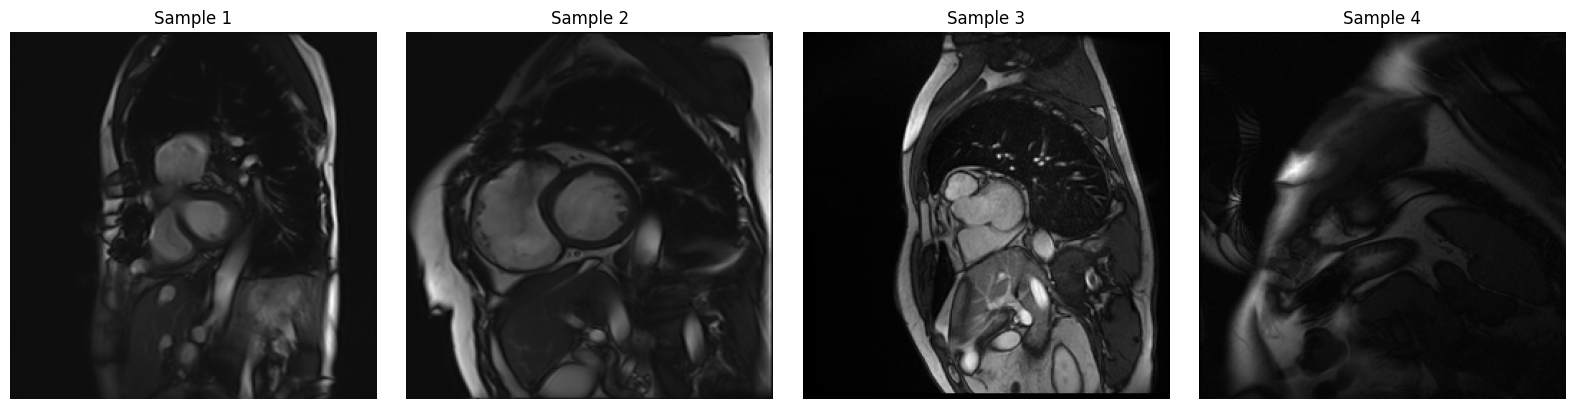


Batch information:
Images shape: torch.Size([12, 1, 256, 256])

Image value range: [-1.00, 1.00]


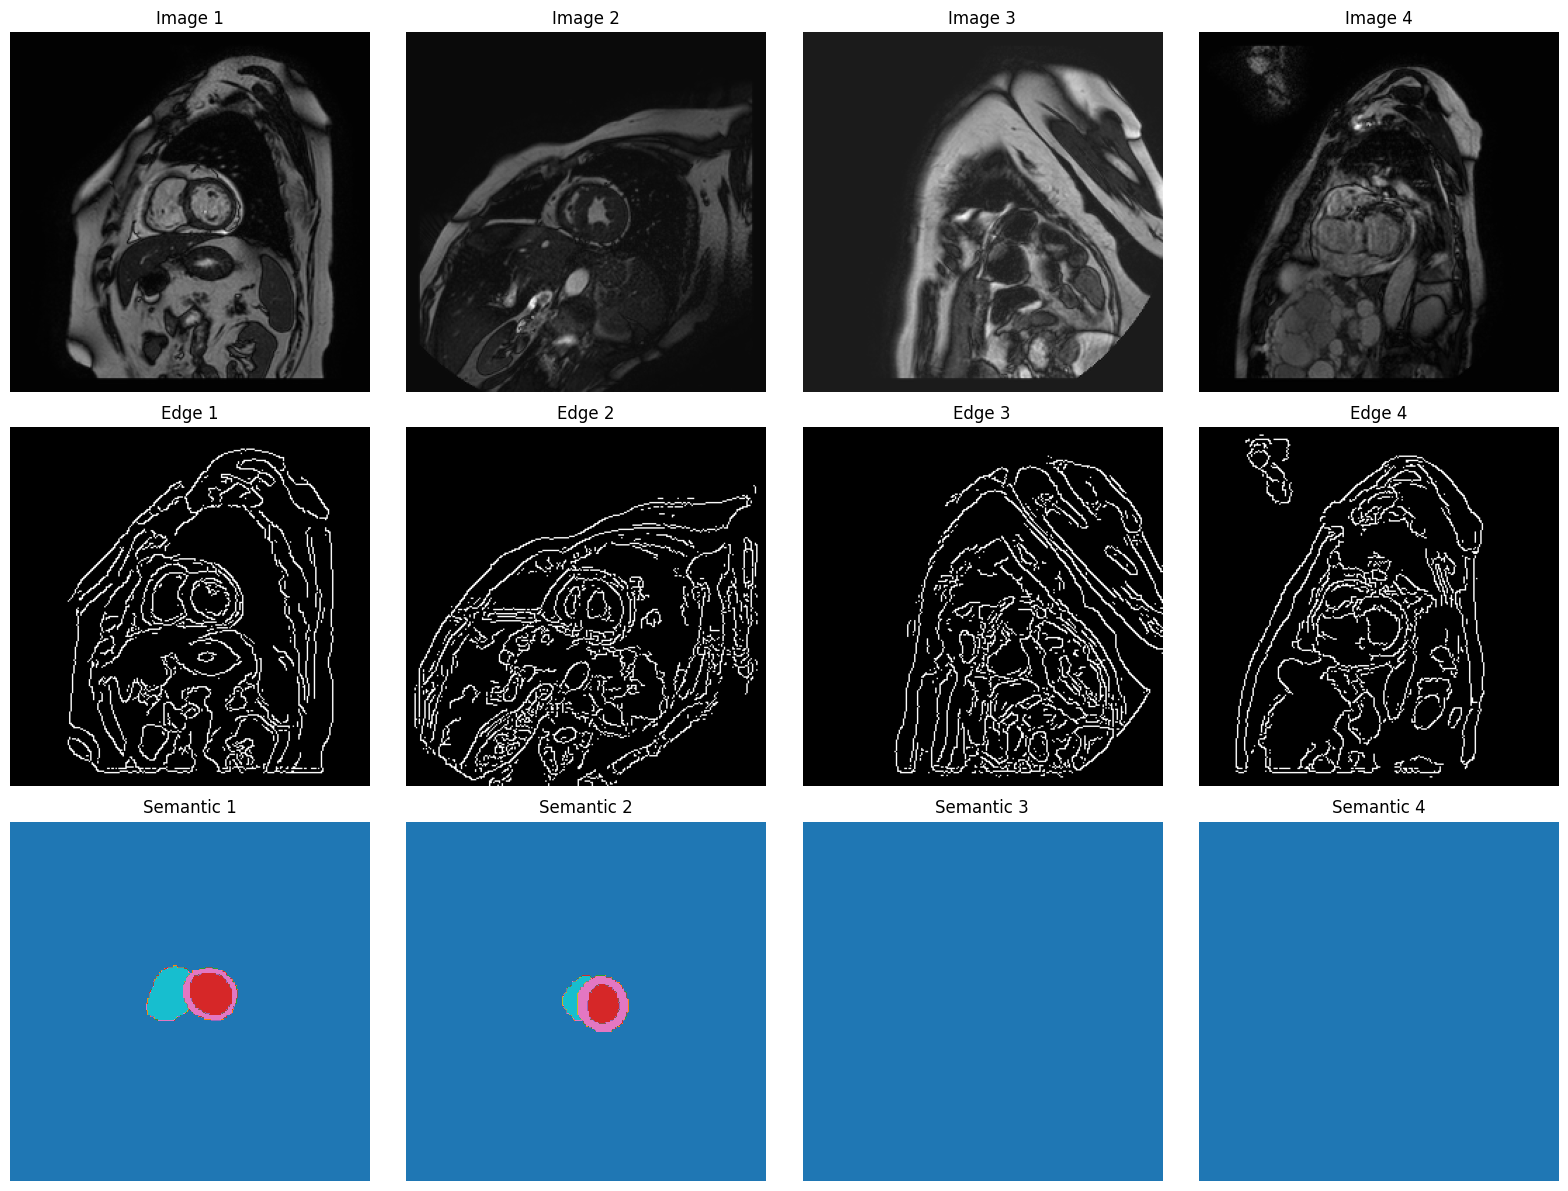


Batch information:
Images shape: torch.Size([12, 1, 256, 256])
Edges shape: torch.Size([12, 256, 256])
Semantic maps shape: torch.Size([12, 4, 256, 256])

Value ranges:
Images: [-1.00, 1.00]
Edges: [0.00, 1.00]
Semantic maps: [0.00, 1.00]


In [4]:
# For VQVAE stage
verify_dataloader(train_dataloader, stage='vqvae')

train_dataset = ImageDataset(train_indices, dataset_config['im_path'], data_indices_json, 'diffusion')

train_dataloader = DataLoader(train_dataset, batch_size=train_config['autoencoder_batch_size'], shuffle=True)

# For diffusion stage
verify_dataloader(train_dataloader, stage='diffusion')